In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from gurobipy import *

<font size="6">**Discrete Model - Capacitated p-Median Facility Location Problem**</font><br>
![](https://i.imgur.com/Nd4031p.png)

Set of customers and PuP is identical

- Decision Variables:
    - yij = if customer i is assigned to PuP j 1;0
    - xj = if PuP j is opened or not 1;0
- Parameters:
    - P = Number of PuPs
    - cij = Shipment cost from PuP to Customer
    - di = Demand of customer i
    - qj = Capacity of PuP j

In [4]:
# Define number of customers here
customers = 1000
demand_per_customer = 5
capacity_per_pup = 400

In [5]:
# Create full Distance Matrix from which we can sample the Customers/PuPs
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
mat_generator = nx.all_pairs_dijkstra_path_length(Gs, weight = "length")
mat_dict = dict(mat_generator)
mat = pd.DataFrame(mat_dict).round(1)
mat = mat.rename_axis("osmid").sort_values(by = ["osmid"])
mat.head()

,10799058,10799066,10799083,10799085,10799087,10799937,10799942,10799945,10799947,10799949,...,8684424129,8917651907,8917667635,8917667643,8917704467,8917704493,8917704495,8917704496,8917704497,8981470540
osmid,,,,,,,,,,,,,,,,,,,,,
10799058,0.0,4595.5,93.1,650.3,389.9,2857.6,3326.5,3247.3,3233.5,3263.2,...,5808.1,10274.0,10505.1,10563.3,6711.6,6754.4,6745.1,6752.8,6765.9,5583.3
10799066,470.5,0.0,412.6,323.3,709.4,3177.1,3646.0,3566.8,3553.0,3582.8,...,6127.6,10593.5,10824.6,10882.8,7031.1,7073.9,7064.6,7072.3,7085.4,5902.8
10799083,704.3,4502.4,0.0,557.2,296.8,2764.5,3233.4,3154.2,3140.4,3170.1,...,5715.0,10180.9,10412.0,10470.2,6618.5,6661.3,6652.0,6659.7,6672.8,5490.2
10799085,147.2,4591.7,89.3,0.0,386.1,2853.8,3322.6,3243.4,3229.7,3259.4,...,5804.3,10270.2,10501.2,10559.5,6707.8,6750.6,6741.3,6749.0,6762.1,5579.5
10799087,4676.1,4205.6,4618.2,4528.9,0.0,2467.7,2936.5,2857.4,2843.6,2873.3,...,5418.2,9884.1,10115.1,10173.4,6321.7,6364.5,6355.2,6362.9,6376.0,5193.4


In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Gs)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
10799058,49.751452,9.926904,3,NaN,POINT (9.92690 49.75145)
10799066,49.753819,9.928881,3,NaN,POINT (9.92888 49.75382)
10799083,49.751798,9.927970,3,NaN,POINT (9.92797 49.75180)
10799085,49.751011,9.927733,3,NaN,POINT (9.92773 49.75101)
10799087,49.754406,9.928837,3,NaN,POINT (9.92884 49.75441)


In [7]:
# Get Customers
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]
nodes_df.head()

,lat,lon
osmid,,
10799058,49.751452,9.926904
10799066,49.753819,9.928881
10799083,49.751798,9.927970
10799085,49.751011,9.927733
10799087,49.754406,9.928837


In [8]:
# Sample customers
sample_nodes_df = nodes_df.sample(n = customers, random_state= 3)
sample_nodes_df.head()

,lat,lon
osmid,,
6034416208,49.791096,9.963971
40932452,49.776658,9.952296
248813018,49.759512,9.931195
1032261863,49.808851,9.905446
51519006,49.794972,9.957999


In [9]:
# Create Customer DF
mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
set_of_all_customers['Demand_C'] = mylist
I = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,Demand_C
osmid,,,
6034416208,49.791096,9.963971,5
40932452,49.776658,9.952296,5
248813018,49.759512,9.931195,5
1032261863,49.808851,9.905446,5
51519006,49.794972,9.957999,5


In [10]:
# Save all the sample nodes osmid for plotting later
Nodes_S = sample_nodes_df.index.values
Nodes_S = Nodes_S.tolist()

In [11]:
# Create Pickup-Point Dataframe
set_of_all_pup = sample_nodes_df.copy()
cap_list = [capacity_per_pup] * customers
set_of_all_pup["Capacity_pup"] = cap_list
J = set_of_all_pup.index.values
set_of_all_pup.head()

,lat,lon,Capacity_pup
osmid,,,
6034416208,49.791096,9.963971,400
40932452,49.776658,9.952296,400
248813018,49.759512,9.931195,400
1032261863,49.808851,9.905446,400
51519006,49.794972,9.957999,400


In [12]:
model = Model()

Academic license - for non-commercial use only - expires 2021-11-24
Using license file C:\Users\michi\gurobi.lic


In [13]:
x = model.addVars(J, name = "x", vtype = GRB.BINARY)
y = model.addVars(I, J, name = "y", vtype = GRB.BINARY)

In [14]:
#model = LpProblem("CpMFLP", LpMinimize)

In [15]:
#x = LpVariable.dicts(name = "x", indexs = J, cat = "Binary")

In [16]:
#y = LpVariable.dicts(name = "y", indexs = (I,J), cat = "Binary")

In [17]:
# Join Distances for the sampled nodes from our Initial Distance Matrix for all nodes 
dist_matrix = pd.DataFrame(index=Nodes_S)
dist_matrix = dist_matrix.rename_axis("osmid")
dist_matrix = dist_matrix.merge(mat, left_index=True, right_index=True)
dist_matrix = dist_matrix[dist_matrix.columns.intersection(Nodes_S)]
dist_matrix = dist_matrix.sort_values(by = ["osmid"])
dist_matrix

,10799058,10799085,10799937,10799942,18177993,18178020,21263521,21263667,21263687,21263784,...,7560229666,7961133186,8010910464,8321645412,8559802281,8630226037,8684424129,8917651907,8917704495,8981470540
osmid,,,,,,,,,,,,,,,,,,,,,
10799058,0.0,650.3,2857.6,3326.5,7395.5,6006.0,7355.7,5880.4,9387.7,9476.0,...,8931.0,10061.5,9318.2,5044.8,6311.1,8752.2,5808.1,10274.0,6745.1,5583.3
10799085,147.2,0.0,2853.8,3322.6,7391.7,6002.2,7351.9,5876.6,9383.9,9472.2,...,8389.3,10057.7,9314.3,5041.0,6307.3,8748.4,5804.3,10270.2,6741.3,5579.5
10799937,2208.4,2061.2,0.0,5383.9,9453.0,8063.5,9413.1,7937.8,11445.1,11533.4,...,10450.5,12118.9,11375.6,7102.2,8368.6,10809.7,7865.5,12331.4,8802.5,7640.7
10799942,2778.7,2631.6,570.4,0.0,6071.5,5072.7,6031.7,4947.1,8454.4,8542.6,...,6887.0,9128.1,8384.8,4111.4,5377.8,7818.9,4484.1,8950.0,5421.1,4649.9
18177993,7912.7,7765.5,5704.3,5321.9,0.0,3371.1,2190.8,3431.4,8110.0,8198.3,...,11777.7,8472.4,7729.1,6466.1,2772.6,7189.6,6850.9,6006.8,2477.9,3099.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8630226037,8350.2,8203.1,6141.8,5571.5,6725.7,3383.8,6376.3,3920.0,2362.2,2450.4,...,12458.5,1749.4,1676.9,5583.0,4564.3,0.0,9118.4,8581.4,5077.6,5439.5
8684424129,6322.4,6175.2,4114.0,4997.0,6848.0,6675.7,6808.2,6093.4,10557.1,10645.3,...,10187.4,11207.2,10463.9,6715.3,6213.0,9921.6,0.0,9726.5,6197.6,5833.2
8917651907,10705.4,10558.2,8497.0,7926.6,5986.1,5359.6,5275.2,5419.9,10004.5,10092.8,...,14637.6,10365.5,9622.2,8966.8,4761.1,9084.0,9710.8,0.0,3515.9,5207.6


![](https://i.imgur.com/Nd4031p.png)

In [18]:
obj = quicksum(dist_matrix.loc[i,j] * y[i,j] for i in I for j in J)

In [19]:
model.setObjective(obj, GRB.MINIMIZE)

In [20]:
for i in I:
    model.addConstr(quicksum(y[i,j] for j in J) == 1)

In [22]:
# Amount of PuPs
P = 20

In [23]:
model.addConstr(quicksum(x[j] for j in J) == P)

<gurobi.Constr *Awaiting Model Update*>

In [24]:
for j in J:
    model.addConstr(quicksum(set_of_all_customers.loc[i].Demand_C * y[i,j] for i in I) <= set_of_all_pup.loc[j].Capacity_pup * x[j])

In [25]:
for j in J:
    for i in I:
        model.addConstr(y[i,j] <= x[j])

In [26]:
model.update()

In [27]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1002001 rows, 1001000 columns and 4002000 nonzeros
Model fingerprint: 0x33796ebd
Variable types: 0 continuous, 1001000 integer (1001000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 5882616.3000
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve time: 9.18s
Presolved: 1002001 rows, 1001000 columns, 4002000 nonzeros
Variable types: 0 continuous, 1001000 integer (1001000 binary)

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.44s

Barrier statistics:
 Dense cols : 1000
 AA' NZ     : 4.002e+06
 Factor NZ  : 8.503e+06 (roughly 900 MBytes of memory)
 Factor Ops : 9.

In [31]:
# PuP Printer
print("The following Pickup-Points are established:")
for j in J:
    if x[j].X >= 0.1:
        print("-{}; Coordinates: {}, {}".format(set_of_all_pup.loc[j].name,
                                                set_of_all_pup.loc[j].lat,
                                                set_of_all_pup.loc[j].lon))

The following Pickup-Points are established:
-10799058; Coordinates: 49.7514519, 9.926904
-27489160; Coordinates: 49.7855924, 9.930666
-30747843; Coordinates: 49.7733913, 9.9232261
-41821780; Coordinates: 49.7874951, 9.9619452
-600161922; Coordinates: 49.7940794, 9.9099899
-4294196112; Coordinates: 49.808323, 9.886186
-148745753; Coordinates: 49.811762, 9.9204396
-304626649; Coordinates: 49.7214878, 9.967224
-254743321; Coordinates: 49.7634304, 9.9413663
-567026710; Coordinates: 49.7988117, 9.9430496
-119789584; Coordinates: 49.7987631, 9.9267464
-27429859; Coordinates: 49.7798412, 9.9454479
-101458388; Coordinates: 49.8035851, 9.9935066
-2290503011; Coordinates: 49.7910588, 9.9971526
-39581470; Coordinates: 49.7616291, 9.9465819
-269543881; Coordinates: 49.8251683, 9.9233312
-113931550; Coordinates: 49.817472, 9.9662343
-40430241; Coordinates: 49.8004603, 9.9516074
-21288066; Coordinates: 49.8109994, 9.9777457
-259846165; Coordinates: 49.7376253, 9.9591382


<font size = 5> **Exploratory Analysis** </font>

In [32]:
# Create a DF which has all the PuP-Customer Connections given by the model


pup_alloc = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_alloc.append(set_of_all_pup.loc[j].name)
pup_lat = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_lat.append(set_of_all_pup.loc[j].lat)
                
pup_lon = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_lon.append(set_of_all_pup.loc[j].lon)                
                
                
customer_alloc = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_alloc.append(set_of_all_customers.loc[i].name)
customer_lat = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_lat.append(set_of_all_customers.loc[i].lat)
                
customer_lon = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_lon.append(set_of_all_customers.loc[i].lon)
                
# Create DF with the lists                
Alloc_DF = pd.DataFrame(list(zip(pup_alloc,pup_lat, pup_lon, customer_alloc, customer_lat, customer_lon)),
               columns =['PuP_ID',"PuP_lat", "PuP_lon", 'C_ID', "C_LAT", "C_LON"])

# Shortest Path Function

def shortest_path(PuP_ID, C_ID):
    length = nx.shortest_path_length(Gs, source=PuP_ID, target=C_ID, weight= "length")                                 
    return length

# Create new Distance column with the haversine function
Alloc_DF["Distance"] = Alloc_DF.apply(lambda x: shortest_path(x["PuP_ID"], x["C_ID"]), axis=1).round(1)

# Shortest Path Time Function

Fs = ox.utils_graph.get_largest_component(G, strongly = True)
Fs = ox.add_edge_speeds(Fs)
Fs = ox.add_edge_travel_times(Fs)

def shortest_path_time(PuP_ID, C_ID):
    time = nx.shortest_path_length(Fs, source=PuP_ID, target=C_ID, weight= "travel_time")                                 
    return time

# Add New Time Column
Alloc_DF["Travel_Time"] = Alloc_DF.apply(lambda x: shortest_path_time(x["PuP_ID"], x["C_ID"]),axis=1)

Alloc_DF = Alloc_DF.sort_values("PuP_ID")
Alloc_DF

,PuP_ID,PuP_lat,PuP_lon,C_ID,C_LAT,C_LON,Distance,Travel_Time
56,10799058,49.751452,9.926904,10799058,49.751452,9.926904,0.0,0.0
391,10799058,49.751452,9.926904,544775748,49.753623,9.928646,495.7,30.2
962,10799058,49.751452,9.926904,760755019,49.751621,9.928048,218.8,15.4
220,10799058,49.751452,9.926904,10799937,49.767498,9.936520,2208.4,110.7
711,10799058,49.751452,9.926904,3202814556,49.751739,9.929751,342.7,24.2
...,...,...,...,...,...,...,...,...
590,4294196112,49.808323,9.886186,835957848,49.803778,9.895605,952.6,71.9
580,4294196112,49.808323,9.886186,5636920540,49.806975,9.885633,205.4,24.2
310,4294196112,49.808323,9.886186,123507774,49.802987,9.893719,1171.2,87.4
323,4294196112,49.808323,9.886186,298903258,49.812467,9.894007,1051.3,97.4


In [33]:
# List of the Opened PuPs and their Coordinates
Location_DF = Alloc_DF.groupby("PuP_ID")["PuP_lat", "PuP_lon"].max()
PuP_Index = Location_DF.index.values
Location_DF

C:\Users\michi\AppData\Local\Temp/ipykernel_72676/1169828555.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Location_DF = Alloc_DF.groupby("PuP_ID")["PuP_lat", "PuP_lon"].max()


,PuP_lat,PuP_lon
PuP_ID,,
10799058,49.751452,9.926904
21288066,49.810999,9.977746
27429859,49.779841,9.945448
27489160,49.785592,9.930666
30747843,49.773391,9.923226
39581470,49.761629,9.946582
40430241,49.800460,9.951607
41821780,49.787495,9.961945
101458388,49.803585,9.993507


In [34]:
# Dataframe to show basic stats about Customer Distances and Travel Times to their assigned Pickup Point
# In Meters and Seconds
Alloc_Stats = pd.DataFrame(index=PuP_Index)
Alloc_Stats = Alloc_Stats.rename_axis("PuP_ID")
Alloc_Stats["Max_Distance"] = Alloc_DF.groupby("PuP_ID")["Distance"].max()
Alloc_Stats["Mean_Distance"] = Alloc_DF.groupby("PuP_ID")["Distance"].mean()
Alloc_Stats["Median_Distance"] = Alloc_DF.groupby("PuP_ID")["Distance"].median()
Alloc_Stats["Max_Time"] = Alloc_DF.groupby("PuP_ID")["Travel_Time"].max()
Alloc_Stats["Mean_Time"] = Alloc_DF.groupby("PuP_ID")["Travel_Time"].mean()
Alloc_Stats["Median_Time"] = Alloc_DF.groupby("PuP_ID")["Travel_Time"].median()
Alloc_Stats = Alloc_Stats.round(1)
Alloc_Stats

,Max_Distance,Mean_Distance,Median_Distance,Max_Time,Mean_Time,Median_Time
PuP_ID,,,,,,
10799058,2208.4,490.3,275.2,110.7,28.9,18.0
21288066,4200.4,1033.6,865.8,269.2,82.6,78.9
27429859,1799.3,889.6,945.4,206.8,97.5,98.4
27489160,2431.2,888.0,859.8,255.0,85.6,78.8
30747843,4239.0,1557.3,1513.7,463.9,165.4,154.4
39581470,3306.9,864.1,584.2,265.7,77.4,54.0
40430241,2219.3,854.6,834.0,165.1,73.4,72.1
41821780,1579.5,867.5,841.8,182.0,91.0,90.4
101458388,1311.8,612.3,586.5,158.2,73.6,70.3


In [35]:
# Create Columns which indicate whether the allocated Customers are within a certain distance/travel time from their PuPs
Alloc_DF_Copy = Alloc_DF.copy()
Alloc_DF_Copy["Within_500m"] = np.where(Alloc_DF_Copy["Distance"] <= 500, 1, 0)
Alloc_DF_Copy["Within_1km"] = np.where(Alloc_DF_Copy["Distance"] <= 1000, 1, 0)
Alloc_DF_Copy["Within_2Min"] = np.where(Alloc_DF_Copy["Travel_Time"] <= 120, 1, 0)
Alloc_DF_Copy["Within_5Min"] = np.where(Alloc_DF_Copy["Travel_Time"] <= 300, 1, 0)
Alloc_DF_Copy = Alloc_DF_Copy.sort_values("PuP_ID")
Alloc_DF_Copy

,PuP_ID,PuP_lat,PuP_lon,C_ID,C_LAT,C_LON,Distance,Travel_Time,Within_500m,Within_1km,Within_2Min,Within_5Min
56,10799058,49.751452,9.926904,10799058,49.751452,9.926904,0.0,0.0,1,1,1,1
391,10799058,49.751452,9.926904,544775748,49.753623,9.928646,495.7,30.2,1,1,1,1
962,10799058,49.751452,9.926904,760755019,49.751621,9.928048,218.8,15.4,1,1,1,1
220,10799058,49.751452,9.926904,10799937,49.767498,9.936520,2208.4,110.7,0,0,1,1
711,10799058,49.751452,9.926904,3202814556,49.751739,9.929751,342.7,24.2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
870,4294196112,49.808323,9.886186,286104802,49.815735,9.882055,1021.2,54.8,0,0,1,1
862,4294196112,49.808323,9.886186,1332257820,49.816598,9.899173,2035.3,196.0,0,0,0,1
859,4294196112,49.808323,9.886186,298903964,49.816196,9.885907,1746.7,138.3,0,0,0,1
481,4294196112,49.808323,9.886186,248063441,49.802380,9.896061,1277.3,63.7,0,0,1,1


In [38]:
Alloc_DF_Copy["PuP_ID"].value_counts()
Alloc_Count = Alloc_DF_Copy["PuP_ID"].value_counts().rename_axis("PuP_ID").to_frame("Customer_Count")
Alloc_Count

,Customer_Count
PuP_ID,
27489160,74
27429859,68
39581470,68
40430241,68
21288066,68
567026710,66
304626649,61
113931550,61
41821780,60


In [36]:
# Create Dataframe which shows percentage of customers within certain distance/travel time of their assigned PuP
# Group by the PuP id, Sum the helper column "Within" for each specific PuP _ID and divide by Total Customers allocated to the PuP to get the percentage of customers within a certain distance/time
Check_DF = pd.DataFrame(index=PuP_Index)
Check_DF = Check_DF.rename_axis("PuP_ID")
Check_DF["Within_Time2"] = Alloc_DF_Copy.groupby("PuP_ID")["Within_2Min"].sum()/Alloc_DF_Copy["PuP_ID"].value_counts()*100
Check_DF["Within_Time5"] = Alloc_DF_Copy.groupby("PuP_ID")["Within_5Min"].sum()/Alloc_DF_Copy["PuP_ID"].value_counts()*100
Check_DF["Within_Dist500"] = Alloc_DF_Copy.groupby("PuP_ID")["Within_500m"].sum()/Alloc_DF_Copy["PuP_ID"].value_counts()*100
Check_DF["Within_Dist1000"] = Alloc_DF_Copy.groupby("PuP_ID")["Within_1km"].sum()/Alloc_DF_Copy["PuP_ID"].value_counts()*100
Check_DF = Check_DF.round(1)
Check_DF

,Within_Time2,Within_Time5,Within_Dist500,Within_Dist1000
PuP_ID,,,,
10799058,100.0,100.0,77.8,88.9
21288066,88.2,100.0,19.1,60.3
27429859,73.5,100.0,19.1,61.8
27489160,86.5,100.0,12.2,63.5
30747843,31.7,97.6,4.9,24.4
39581470,79.4,100.0,33.8,73.5
40430241,85.3,100.0,27.9,61.8
41821780,78.3,100.0,15.0,58.3
101458388,79.3,100.0,41.4,79.3


<font size = 5>**Color Coded PuP Allocation Map**</font>

In [85]:
alloc_list = Alloc_DF.groupby("PuP_ID")["C_ID"].apply(list)
alloc_list

PuP_ID
10799058      [10799058, 544775748, 760755019, 10799937, 320...
21288066      [332603246, 5732140853, 151014096, 29761329, 1...
27429859      [25584368, 8321645412, 30751978, 29560039, 242...
27489160      [29013833, 27353416, 27489458, 83734059, 27353...
30747843      [362242524, 206147097, 362591672, 248067190, 2...
39581470      [39778128, 281266824, 266382515, 335023285, 33...
40430241      [36483498, 309921610, 51519854, 107780249, 515...
41821780      [4346460319, 1020233295, 1023364842, 27429947,...
101458388     [310419547, 101458333, 310425045, 259486196, 3...
113931550     [319429083, 360797059, 265894528, 319429082, 3...
119789584     [119788913, 119703341, 119789442, 54140220, 11...
148745753     [148745753, 2493757837, 148745763, 355917350, ...
254743321     [248813018, 251053250, 248812996, 36720665, 36...
259846165     [304638452, 259846147, 708997633, 336569878, 3...
269543881     [311596247, 364909260, 311596151, 311596440, 3...
304626649     [39779603, 37009579

In [90]:
alloc_list.iloc[0]

[10799058,
 544775748,
 760755019,
 10799937,
 3202814556,
 3733283077,
 3202814543,
 10799085,
 3733283062]

In [91]:
P

20

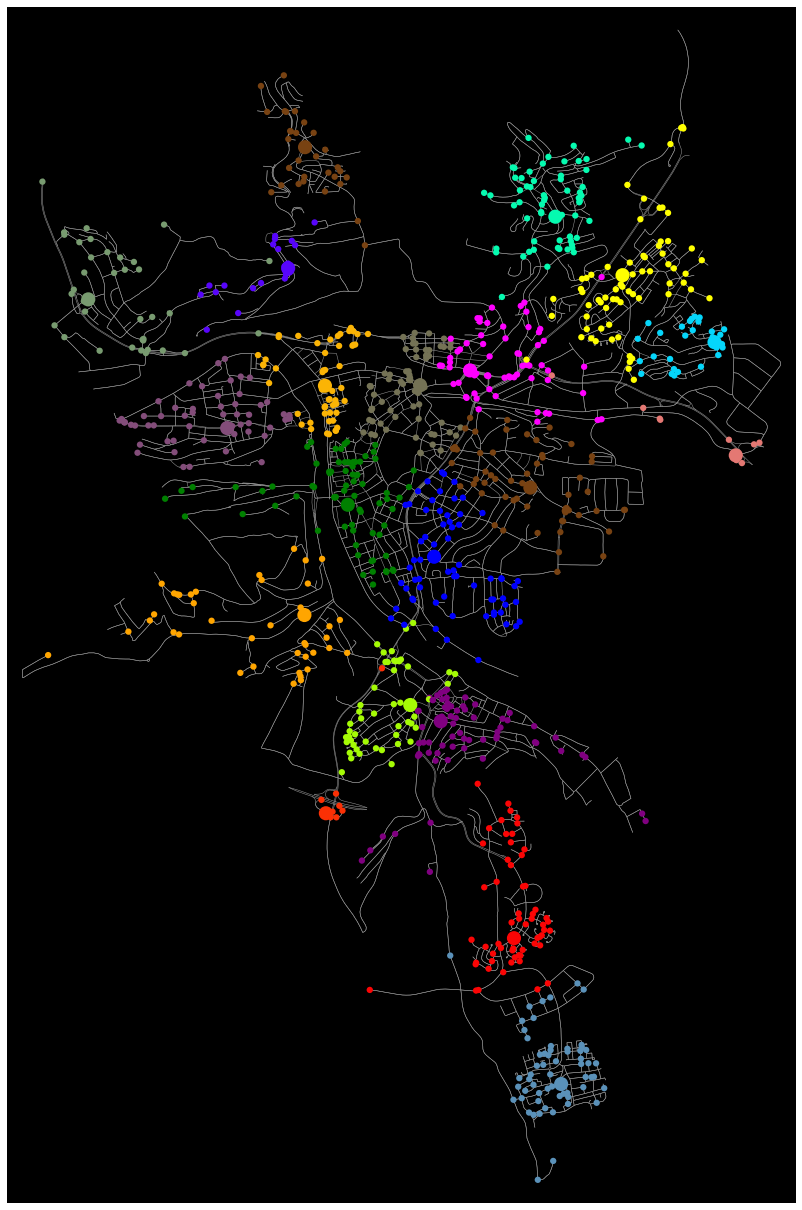

In [89]:
# Color Coded Clustering
warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# If PuP node size 200, if Customer 50
ns = []
for node in G.nodes():
    if node in PuP_Index:
        ns.append(200)
    elif node in Nodes_S:
        ns.append(40)
    else:
        ns.append(0)
# Color Code every PuP/Allocated customers   


# How many pups do we have = P
P = 20

nc = []

for node in G.nodes():
    if node in alloc_list.iloc[P-20]: 
        nc.append("#FB3005")
    elif node in alloc_list.iloc[P-19]:
        nc.append("yellow")
    elif node in alloc_list.iloc[P-18]:
        nc.append("blue")
    elif node in alloc_list.iloc[P-17]:
        nc.append("green")
    elif node in alloc_list.iloc[P-16]:
        nc.append("orange")
    elif node in alloc_list.iloc[P-15]:
        nc.append("purple")
    elif node in alloc_list.iloc[P-14]:
        nc.append("magenta")
    elif node in alloc_list.iloc[P-13]:
        nc.append("#784212")
    elif node in alloc_list.iloc[P-12]:
        nc.append("#05D6FB")
    elif node in alloc_list.iloc[P-11]:
        nc.append("#05FBB0")
    elif node in alloc_list.iloc[P-10]:
        nc.append("#FBB405")
    elif node in alloc_list.iloc[P-9]:
        nc.append("#5705FB")
    elif node in alloc_list.iloc[P-8]:
        nc.append("#A5FB05")
    elif node in alloc_list.iloc[P-7]:
        nc.append("#FB0505")
    elif node in alloc_list.iloc[P-6]:
        nc.append("#784212")
    elif node in alloc_list.iloc[P-5]:
        nc.append("#5A91B9")
    elif node in alloc_list.iloc[P-4]:
        nc.append("#747255")
    elif node in alloc_list.iloc[P-3]:
        nc.append("#834D7A")
    elif node in alloc_list.iloc[P-2]:
        nc.append("#E47873")
    elif node in alloc_list.iloc[P-1]:
        nc.append("#789B70")
    else:
        nc.append("white")
        
fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [ ]:
# Color Coded Clustering
warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# If PuP node size 200, if Customer 50
ns = []
for node in G.nodes():
    if node in PuP_Index:
        ns.append(200)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
# Color Code every PuP/Allocated customers   


# PuP_ID
# 10799058      [10799058, 544775748, 760755019, 10799937, 320...
# 21288066      [332603246, 5732140853, 151014096, 29761329, 1...
# 27429859      [25584368, 8321645412, 30751978, 29560039, 242...
# 27489160      [29013833, 27353416, 27489458, 83734059, 27353...
# 30747843      [362242524, 206147097, 362591672, 248067190, 2...
# 39581470      [39778128, 281266824, 266382515, 335023285, 33...
# 40430241      [36483498, 309921610, 51519854, 107780249, 515...
# 41821780      [4346460319, 1020233295, 1023364842, 27429947,...
# 101458388     [310419547, 101458333, 310425045, 259486196, 3...
# 113931550     [319429083, 360797059, 265894528, 319429082, 3...
# 119789584     [119788913, 119703341, 119789442, 54140220, 11...
# 148745753     [148745753, 2493757837, 148745763, 355917350, ...
# 254743321     [248813018, 251053250, 248812996, 36720665, 36...
# 259846165     [304638452, 259846147, 708997633, 336569878, 3...
# 269543881     [311596247, 364909260, 311596151, 311596440, 3...
# 304626649     [39779603, 3700957947, 304626646, 360654756, 3...
# 567026710     [33171211, 567026710, 4986365159, 175629191, 3...
# 600161922     [232794752, 720571230, 295548268, 290817559, 6...
# 2290503011    [21263687, 21286327, 21263784, 2290503011, 319...
# 4294196112 



nc = []
for node in G.nodes():
    for i in PuP_Index:
        if node in teste.loc[i]: 
            nc.append("#FB3005")
#     elif node in teste.loc[21288066]:
#         nc.append("yellow")
#     elif node in teste.loc[27429859]:
#         nc.append("blue")
#     elif node in teste.loc[27489160]:
#         nc.append("green")
#     elif node in teste.loc[30747843]:
#         nc.append("orange")
#     elif node in teste.loc[39581470]:
#         nc.append("purple")
#     elif node in teste.loc[40430241]:
#         nc.append("magenta")
#     elif node in teste.loc[41821780]:
#         nc.append("#784212")
#     elif node in teste.loc[101458388]:
#         nc.append("#05D6FB")
#     elif node in teste.loc[113931550]:
#         nc.append("#05FBB0")
#     elif node in teste.loc[119789584]:
#         nc.append("#FBB405")
#     elif node in teste.loc[148745753]:
#         nc.append("#5705FB")
#     elif node in teste.loc[254743321]:
#         nc.append("#A5FB05")
#     elif node in teste.loc[259846165]:
#         nc.append("#FB0505")
#     elif node in teste.loc[269543881]:
#         nc.append("#FB8705")
    else:
        nc.append("white")
        
fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [ ]:
nc

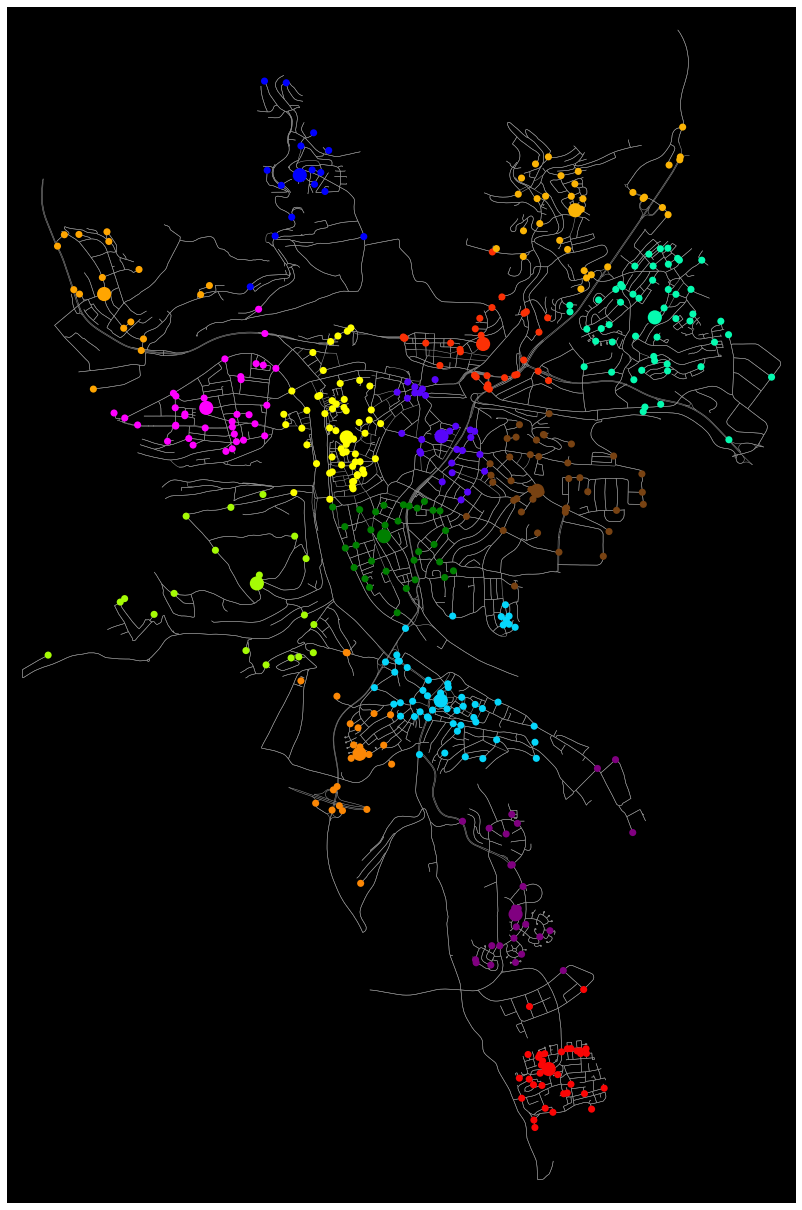

In [170]:
# Color Coded Clustering
warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# If PuP node size 200, if Customer 50
ns = []
for node in G.nodes():
    if node in OSMID_PUP_LIST:
        ns.append(200)
    elif node in OSMID_C_LIST:
        ns.append(50)
    else:
        ns.append(0)
# Color Code every PuP/Allocated customers        
nc = []
for node in G.nodes():
    if node in OSMID_C_8: 
        nc.append("#FB3005")
    elif node in OSMID_C_37:
        nc.append("yellow")
    elif node in OSMID_C_121:
        nc.append("blue")
    elif node in OSMID_C_174:
        nc.append("green")
    elif node in OSMID_C_219:
        nc.append("orange")
    elif node in OSMID_C_222:
        nc.append("purple")
    elif node in OSMID_C_235:
        nc.append("magenta")
    elif node in OSMID_C_316:
        nc.append("#784212")
    elif node in OSMID_C_338:
        nc.append("#05D6FB")
    elif node in OSMID_C_342:
        nc.append("#05FBB0")
    elif node in OSMID_C_395:
        nc.append("#FBB405")
    elif node in OSMID_C_412:
        nc.append("#5705FB")
    elif node in OSMID_C_413:
        nc.append("#A5FB05")
    elif node in OSMID_C_427:
        nc.append("#FB0505")
    elif node in OSMID_C_499:
        nc.append("#FB8705")
    else:
        nc.append("white")
        
fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

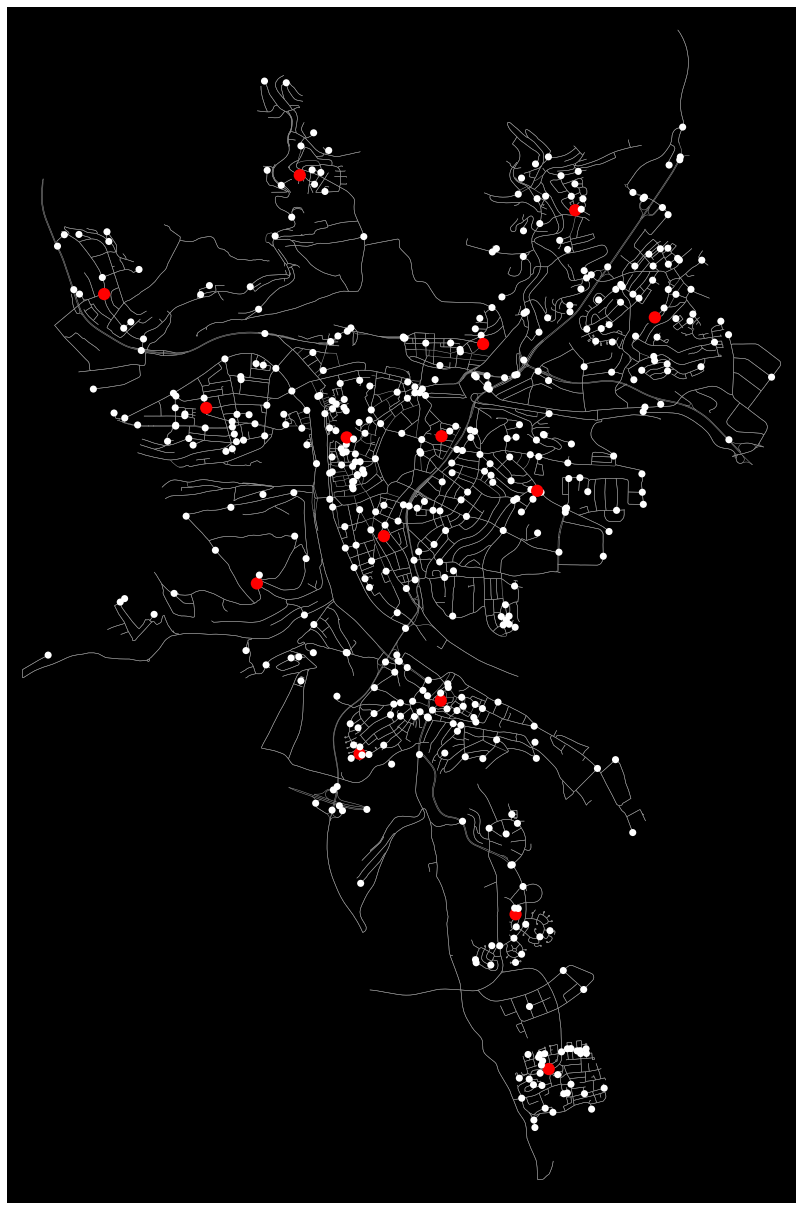

In [37]:
#Check for the nodes that the model selected
warnings.filterwarnings("ignore")


place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)


ns = []
for node in G.nodes():
    if node in PuP_Index:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in G.nodes():
    if node in PuP_Index: 
        nc.append("red")
    else:
        nc.append("white")
        
fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [ ]:

Dist_solution = sum(dist_matrix.loc[i,j] * y[i][j].varValue for i in I for j in J)
print("Sum Min Distance {}".format(Dist_solution))